# Customer Churn Prediction - Model Training

In this notebook, we will:
1. Load the raw data.
2. Apply the preprocessing steps defined in the EDA phase.
3. Train the Models.
4. Evaluate the model performance.

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [56]:
df = pd.read_excel("../data/raw/Telco_customer_churn.xlsx")
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## 2. Preprocessing
We will apply the cleaning steps discovered during EDA

In [57]:
# 1. Fix Total Charges
df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
df['Total Charges'] = df['Total Charges'].fillna(0)

# 2. Drop Unnecessary Columns
drop_cols = ['CustomerID', 'Count', 'Country', 'State', 'City', 
             'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 
             'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason']

df_clean = df.drop(columns=drop_cols)

# Define features (X) and target (y)
X = df_clean.drop('Churn Value', axis=1)
y = df_clean['Churn Value']

print(f"Original Shape: {df.shape}")
print(f"Feature Shape: {X.shape}")

Original Shape: (7043, 33)
Feature Shape: (7043, 19)


## 3. Train-Test Split

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 5634
Testing samples: 1409


## 4. Feature Engineering Pipeline (ColumnTransformer)
We will use `ColumnTransformer` to apply `StandardScaler` to numerical columns and `OneHotEncoder` to categorical columns.

In [59]:
# Identify numerical and categorical columns
num_cols = ['Tenure Months', 'Monthly Charges', 'Total Charges']
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ])

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data
X_test_processed = preprocessor.transform(X_test)

# Get feature names after encoding
feature_names = num_cols + preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols).tolist()

# Convert sparse matrix to dense array for Keras (if necessary)
if hasattr(X_train_processed, 'toarray'):
    X_train_dense = X_train_processed.toarray()
    X_test_dense = X_test_processed.toarray()
else:
    X_train_dense = X_train_processed
    X_test_dense = X_test_processed

print("Preprocessing Complete!")
print(f"Processed Feature Shape: {X_train_dense.shape}")

Preprocessing Complete!
Processed Feature Shape: (5634, 30)


## 5. Baseline Model: Logistic Regression (Scaled)

In [60]:
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_processed, y_train)

y_pred = log_model.predict(X_test_processed)

print("Logistic Regression (Scaled) Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Logistic Regression (Scaled) Accuracy: 0.8041163946061036

Confusion Matrix:
 [[900 109]
 [167 233]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1009
           1       0.68      0.58      0.63       400

    accuracy                           0.80      1409
   macro avg       0.76      0.74      0.75      1409
weighted avg       0.80      0.80      0.80      1409



## 6. Advanced Model: Random Forest

In [61]:
from sklearn.ensemble import RandomForestClassifier

# 1. Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Train
rf_model.fit(X_train_processed, y_train)

# 3. Predict
y_pred_rf = rf_model.predict(X_test_processed)

# 4. Evaluate
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7877927608232789

Confusion Matrix:
 [[906 103]
 [196 204]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86      1009
           1       0.66      0.51      0.58       400

    accuracy                           0.79      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.79      0.78      1409



## 7. Handling Class Imbalance (SMOTE)
Our previous models had low Recall for Churners (Class 1). We will use SMOTE to generate synthetic samples.

In [62]:
from imblearn.over_sampling import SMOTE

# 1. Initialize SMOTE
smote = SMOTE(random_state=42)

# 2. Resample the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print(f"Original Training Shape: {y_train.value_counts()}")
print(f"Resampled Training Shape: {y_train_smote.value_counts()}")

# 3. Retrain Random Forest on Balanced Data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote.fit(X_train_smote, y_train_smote)

# 4. Predict
y_pred_smote = rf_smote.predict(X_test_processed)

# 5. Evaluate
print("Random Forest (SMOTE) Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))

Original Training Shape: Churn Value
0    4165
1    1469
Name: count, dtype: int64
Resampled Training Shape: Churn Value
0    4165
1    4165
Name: count, dtype: int64
Random Forest (SMOTE) Accuracy: 0.7934705464868701

Confusion Matrix:
 [[871 138]
 [153 247]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.86      1009
           1       0.64      0.62      0.63       400

    accuracy                           0.79      1409
   macro avg       0.75      0.74      0.74      1409
weighted avg       0.79      0.79      0.79      1409



## 8. Gradient Boosting: XGBoost (Tuned)
We will now tune XGBoost hyperparameters to maximize Recall.

In [63]:
from xgboost import XGBClassifier

# 1. Define the parameter grid
param_grid = {
    'scale_pos_weight': [1, 3, 5],  # Key for imbalance
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200]
}

# 2. Initialize XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 3. Setup GridSearchCV (Optimizing for Recall)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',  # Focus on catching churners
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 4. Train with GridSearch (Using SMOTE data)
print("Starting Grid Search... This may take a minute.")
grid_search.fit(X_train_smote, y_train_smote)

# 5. Best Parameters
print("Best Parameters:", grid_search.best_params_)

# 6. Evaluate Best Model
best_xgb = grid_search.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test_processed)

print("\nXGBoost (Tuned) Accuracy:", accuracy_score(y_test, y_pred_xgb_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb_tuned))

Starting Grid Search... This may take a minute.
Fitting 3 folds for each of 54 candidates, totalling 162 fits


Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 5}

XGBoost (Tuned) Accuracy: 0.49751596877217885

Confusion Matrix:
 [[310 699]
 [  9 391]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.31      0.47      1009
           1       0.36      0.98      0.52       400

    accuracy                           0.50      1409
   macro avg       0.67      0.64      0.50      1409
weighted avg       0.80      0.50      0.48      1409



## 9. Deep Learning: Neural Network (Keras)
Let's build a Neural Network to see if it can capture non-linear patterns better than tree models.

In [ ]:
# 1. Calculate Class Weights (to handle imbalance)
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weight_dict)

# 2. Build the Model
model = Sequential()
model.add(Dense(64, input_dim=X_train_dense.shape[1], activation='relu'))
model.add(Dropout(0.3))  # Regularization
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# 3. Compile
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])

# 4. Train
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_dense, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# 5. Evaluate
y_pred_nn_prob = model.predict(X_test_dense)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int)

print("\nNeural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))

Class Weights: {0: np.float64(0.6763505402160864), 1: np.float64(1.9176310415248468)}
Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6845 - loss: 0.5728 - recall: 0.7810 - val_accuracy: 0.7516 - val_loss: 0.5100 - val_recall: 0.8369
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.7517 - loss: 0.5019 - recall: 0.7877 - val_accuracy: 0.7516 - val_loss: 0.4945 - val_recall: 0.8333
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.7460 - loss: 0.4870 - recall: 0.8062 - val_accuracy: 0.7791 - val_loss: 0.4453 - val_recall: 0.7908
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7548 - loss: 0.4777 - recall: 0.8088 - val_accuracy: 0.7622 - val_loss: 0.4700 - val_recall: 0.8298
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.7468 - loss: 0.4734 - recall: 0.8155 - val_accuracy: 0.7657 - val_loss: 0.4597 - val_recall: 0.8262
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.75

## 10. Feature Importance Analysis
Let's see which features the model thinks are most important for predicting churn.

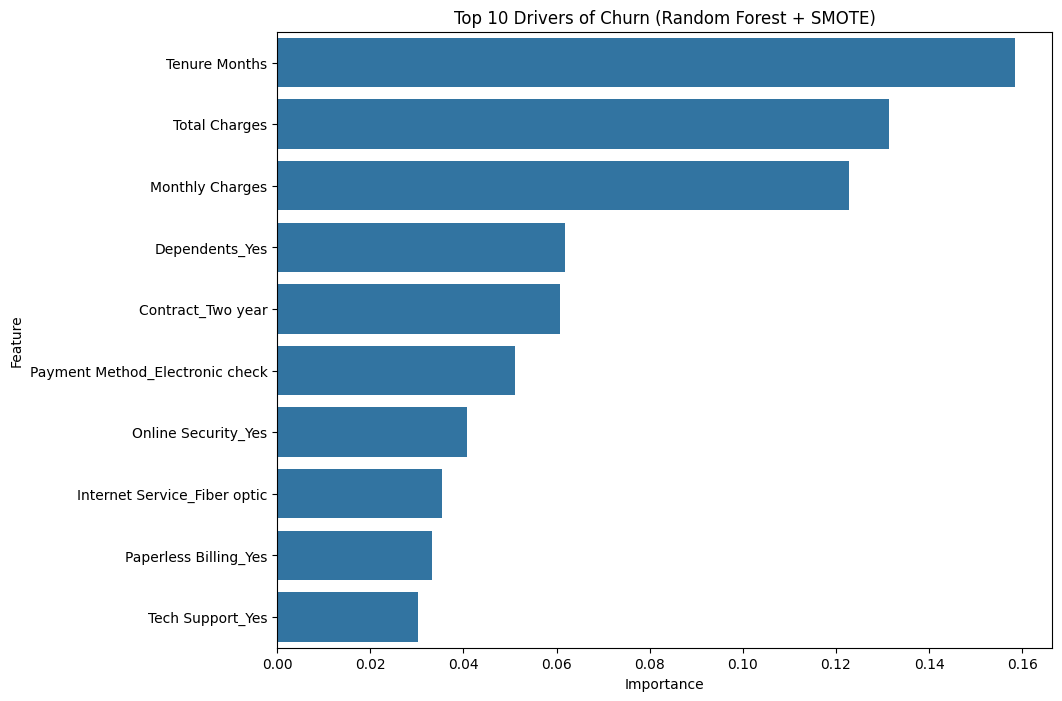

In [65]:
# Get feature importances (using Random Forest for now as it's easier to interpret directly)
importances = rf_smote.feature_importances_

# Create a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Drivers of Churn (Random Forest + SMOTE)')
plt.show()

In [66]:
# Save the model
model.save('churn_model.h5')
print("Model saved as churn_model.h5")

Model saved as churn_model.h5


In [ ]:
from sklearn.inspection import permutation_importance

class KerasWrapper:
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        pass
    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")
    def score(self, X, y):
        return self.model.evaluate(X, y, verbose=0)[1]

wrapped_model = KerasWrapper(model)

results = permutation_importance(wrapped_model, X_test_dense, y_test, n_repeats=10, random_state=42, n_jobs=1)

importance_df_nn = pd.DataFrame({
    'Feature': feature_names,
    'Importance': results.importances_mean
})
importance_df_nn = importance_df_nn.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df_nn.head(10))
plt.title('Top 10 Drivers of Churn (Neural Network Permutation Importance)')
plt.show()